In [1]:
import pandas
import konlpy
import gensim
import pandas as pd
import tensorflow as tf

# 데이터를 읽어봅시다. 
train_data = pd.read_table('./ratings_train.txt')
test_data = pd.read_table('./ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
print(train_data.shape)
print(test_data.shape)

(150000, 3)
(50000, 3)


In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

word_to_index = {}

def load_data(train_data, test_data, num_words=50000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<PAD>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [6]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


In [7]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens) * 100}%가 maxlen 설정값 이내에 포함됩니다. ')

pad_sequences maxlen :  41
전체 문장의 93.42988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [8]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

LSTM 모델

In [9]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
lstm_model.add(tf.keras.layers.LSTM(8))
lstm_model.add(tf.keras.layers.Dense(8, activation='relu'))
lstm_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


Conv1D 모델

In [10]:
conv1d_model = tf.keras.Sequential()
conv1d_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
conv1d_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
conv1d_model.add(tf.keras.layers.MaxPooling1D(5))
conv1d_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
conv1d_model.add(tf.keras.layers.GlobalMaxPooling1D())
conv1d_model.add(tf.keras.layers.Dense(8, activation='relu'))
conv1d_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

conv1d_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

GlobalMaxPooling 모델

In [11]:
gmaxp_model = tf.keras.Sequential()
gmaxp_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
gmaxp_model.add(tf.keras.layers.GlobalMaxPooling1D())
gmaxp_model.add(tf.keras.layers.Dense(8, activation='relu'))
gmaxp_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

gmaxp_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


train, val 분리

In [12]:
X_val = X_train[:20000]
Y_val = y_train[:20000]

partial_X_train = X_train[20000:]
partial_Y_train = y_train[20000:]

print(partial_X_train.shape)
print(partial_Y_train.shape)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(Y_val.shape)

(126182, 41)
(126182,)
(146182, 41)
(146182,)
(20000, 41)
(20000,)


lstm모델 훈련 및 평가

In [13]:
lstm_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20

lstm_history = lstm_model.fit(partial_X_train,
                    partial_Y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, Y_val),
                    verbose=1)

lstm_results = lstm_model.evaluate(X_test,  y_test, verbose=2)

print(lstm_results)

Epoch 1/20
247/247 [==============================] - 31s 7ms/step - loss: 0.5092 - accuracy: 0.7803 - val_loss: 0.3729 - val_accuracy: 0.8411
Epoch 2/20
247/247 [==============================] - 1s 5ms/step - loss: 0.3394 - accuracy: 0.8573 - val_loss: 0.3477 - val_accuracy: 0.8481
Epoch 3/20
247/247 [==============================] - 1s 5ms/step - loss: 0.3117 - accuracy: 0.8705 - val_loss: 0.3432 - val_accuracy: 0.8532
Epoch 4/20
247/247 [==============================] - 1s 5ms/step - loss: 0.2962 - accuracy: 0.8777 - val_loss: 0.3472 - val_accuracy: 0.8540
Epoch 5/20
247/247 [==============================] - 1s 5ms/step - loss: 0.2832 - accuracy: 0.8836 - val_loss: 0.3432 - val_accuracy: 0.8554
Epoch 6/20
247/247 [==============================] - 1s 5ms/step - loss: 0.2716 - accuracy: 0.8889 - val_loss: 0.3507 - val_accuracy: 0.8519
Epoch 7/20
247/247 [==============================] - 1s 5ms/step - loss: 0.2586 - accuracy: 0.8953 - val_loss: 0.3484 - val_accuracy: 0.8534
Epoch

conv1D모델 훈련 및 평가

In [14]:
conv1d_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20

conv1d_history = conv1d_model.fit(partial_X_train,
                    partial_Y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, Y_val),
                    verbose=1)

conv1d_results = conv1d_model.evaluate(X_test,  y_test, verbose=2)

print(conv1d_results)

Epoch 1/20
247/247 [==============================] - 17s 6ms/step - loss: 0.4803 - accuracy: 0.7620 - val_loss: 0.3512 - val_accuracy: 0.8470
Epoch 2/20
247/247 [==============================] - 1s 5ms/step - loss: 0.3232 - accuracy: 0.8622 - val_loss: 0.3386 - val_accuracy: 0.8534
Epoch 3/20
247/247 [==============================] - 1s 5ms/step - loss: 0.2887 - accuracy: 0.8802 - val_loss: 0.3391 - val_accuracy: 0.8539
Epoch 4/20
247/247 [==============================] - 1s 5ms/step - loss: 0.2596 - accuracy: 0.8949 - val_loss: 0.3444 - val_accuracy: 0.8525
Epoch 5/20
247/247 [==============================] - 1s 5ms/step - loss: 0.2286 - accuracy: 0.9110 - val_loss: 0.3611 - val_accuracy: 0.8530
Epoch 6/20
247/247 [==============================] - 1s 4ms/step - loss: 0.1959 - accuracy: 0.9275 - val_loss: 0.3887 - val_accuracy: 0.8454
Epoch 7/20
247/247 [==============================] - 1s 5ms/step - loss: 0.1641 - accuracy: 0.9419 - val_loss: 0.4249 - val_accuracy: 0.8407
Epoch

global max pooling모델 훈련 및 평가

In [15]:
gmaxp_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20

gmaxp_history = gmaxp_model.fit(partial_X_train,
                    partial_Y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, Y_val),
                    verbose=1)

gmaxp_results = gmaxp_model.evaluate(X_test,  y_test, verbose=2)

print(gmaxp_results)

Epoch 1/20
247/247 [==============================] - 1s 4ms/step - loss: 0.5737 - accuracy: 0.7637 - val_loss: 0.4167 - val_accuracy: 0.8252
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 0.3724 - accuracy: 0.8411 - val_loss: 0.3602 - val_accuracy: 0.8399
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.3268 - accuracy: 0.8616 - val_loss: 0.3496 - val_accuracy: 0.8450
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.3011 - accuracy: 0.8741 - val_loss: 0.3489 - val_accuracy: 0.8489
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.2823 - accuracy: 0.8836 - val_loss: 0.3526 - val_accuracy: 0.8466
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.2674 - accuracy: 0.8910 - val_loss: 0.3576 - val_accuracy: 0.8457
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.2545 - accuracy: 0.8967 - val_loss: 0.3644 - val_accuracy: 0.8450
Epoch 

### 결과값 시각화  
차례대로  
LSTM의 loss&val_loss, acc&val_acc  
Conv1D의 loss&val_loss, acc&val_acc  
GlobalMaxPooling의 loss&val_loss, acc&val_acc  

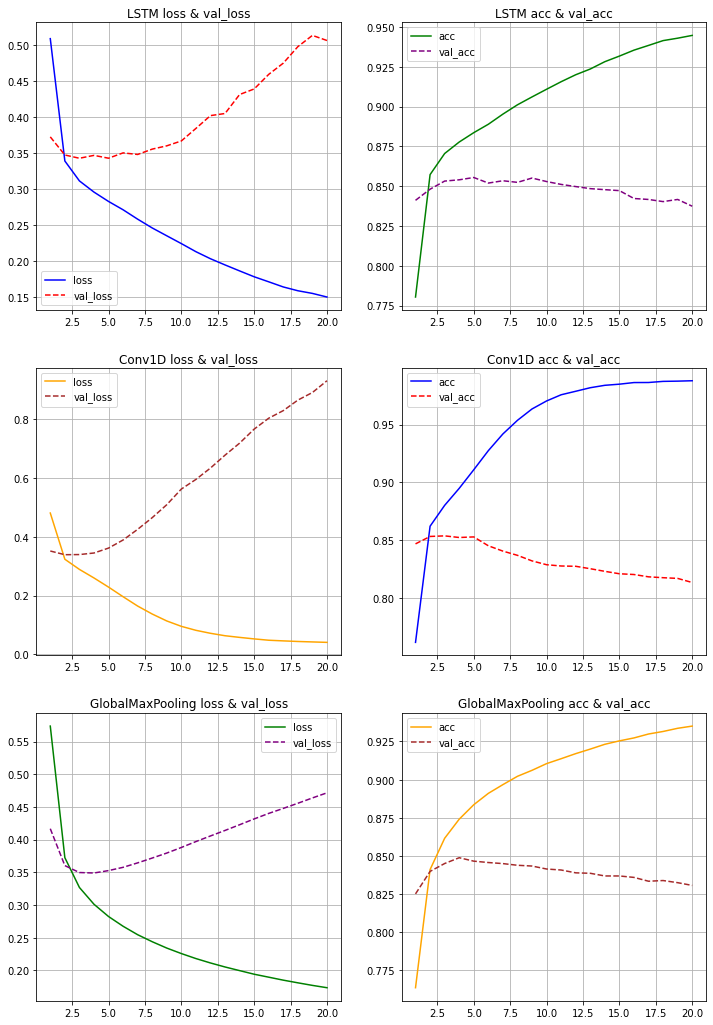

In [16]:
import matplotlib.pyplot as plt

lstm_dict = lstm_history.history
conv1d_dict = conv1d_history.history
gmaxp_dict = gmaxp_history.history

l_acc = lstm_dict['accuracy']
l_val_acc = lstm_dict['val_accuracy']
l_loss = lstm_dict['loss']
l_val_loss = lstm_dict['val_loss']

c_acc = conv1d_dict['accuracy']
c_val_acc = conv1d_dict['val_accuracy']
c_loss = conv1d_dict['loss']
c_val_loss = conv1d_dict['val_loss']

g_acc = gmaxp_dict['accuracy']
g_val_acc = gmaxp_dict['val_accuracy']
g_loss = gmaxp_dict['loss']
g_val_loss = gmaxp_dict['val_loss']

epochs = range(1, len(l_acc) + 1)

fig, axs = plt.subplots(3, 2, figsize=(12, 18))

axs[0, 0].plot(epochs, l_loss, label='loss', linestyle='-', color='blue')
axs[0, 0].plot(epochs, l_val_loss, label='val_loss', linestyle='--', color='red')
axs[0, 0].set_title('LSTM loss & val_loss')
axs[0, 0].legend()
axs[0, 0].grid(True)

axs[0, 1].plot(epochs, l_acc, label='acc', linestyle='-', color='green')
axs[0, 1].plot(epochs, l_val_acc, label='val_acc', linestyle='--', color='purple')
axs[0, 1].set_title('LSTM acc & val_acc')
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[1, 0].plot(epochs, c_loss, label='loss', linestyle='-', color='orange')
axs[1, 0].plot(epochs, c_val_loss, label='val_loss', linestyle='--', color='brown')
axs[1, 0].set_title('Conv1D loss & val_loss')
axs[1, 0].legend()
axs[1, 0].grid(True)

axs[1, 1].plot(epochs, c_acc, label='acc', linestyle='-', color='blue')
axs[1, 1].plot(epochs, c_val_acc, label='val_acc', linestyle='--', color='red')
axs[1, 1].set_title('Conv1D acc & val_acc')
axs[1, 1].legend()
axs[1, 1].grid(True)

axs[2, 0].plot(epochs, g_loss, label='loss', linestyle='-', color='green')
axs[2, 0].plot(epochs, g_val_loss, label='val_loss', linestyle='--', color='purple')
axs[2, 0].set_title('GlobalMaxPooling loss & val_loss')
axs[2, 0].legend()
axs[2, 0].grid(True)

axs[2, 1].plot(epochs, g_acc, label='acc', linestyle='-', color='orange')
axs[2, 1].plot(epochs, g_val_acc, label='val_acc', linestyle='--', color='brown')
axs[2, 1].set_title('GlobalMaxPooling acc & val_acc')
axs[2, 1].legend()
axs[2, 1].grid(True)

plt.show()

대부분 에포크 5근방에서 과적합이 일어났다.
- 모델의 깊이가 모자란것 같다.

### 임베딩 벡터

In [17]:
embedding_layer = lstm_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 16)


In [18]:
word2vec_file_path = './word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = lstm_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [19]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([-0.01497916, -0.06604685,  0.04843125,  0.00388212, -0.00052395,
        0.01074888,  0.07411043, -0.03607967,  0.00746106,  0.00329433,
        0.09485079, -0.07181956, -0.09343786,  0.03197189, -0.11714429,
       -0.09018214], dtype=float32)

임베딩벡터를 활용해 유사어 찾기

In [20]:
word_vectors.similar_by_word('영화')

[('ㅇㅋ', 0.848122239112854),
 ('습니다', 0.8259631991386414),
 ('어요', 0.8218173384666443),
 ('음', 0.8159040808677673),
 ('!', 0.8113614916801453),
 ('흥하', 0.8001246452331543),
 ('아요', 0.7771081924438477),
 ('싶', 0.776673436164856),
 ('달린다', 0.7679622769355774),
 ('네요', 0.7676928043365479)]

In [21]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word2vec_file_path = './word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)

print(word_vectors.wv.vector_size)
print(len(word_vectors.wv.key_to_index))

100
302960


데이터 전처리

pretrained 모델을 활용해 유사어 찾기

In [22]:
word_vectors.wv.similar_by_word('영화')

[('드라마', 0.8418774008750916),
 ('뮤지컬', 0.7775140404701233),
 ('코미디', 0.7489107251167297),
 ('다큐멘터리', 0.7401294708251953),
 ('헐리우드', 0.7397844195365906),
 ('애니메이션', 0.7170552015304565),
 ('독립영화', 0.7113528251647949),
 ('로맨틱', 0.7107657194137573),
 ('장편', 0.7101576924324036),
 ('극영화', 0.7045413255691528)]

학습된 임베딩 벡터를 활용한 검색에서는 영화와 거리가 멀어보이는 단어들이 보이지만 pretrained모델에서는 드라마, 뮤지컬, 헐리우드 등 상식적으로 유사한 단어들이 결과값으로 출력되었다. 추가적으로 워드벡터의 차원수가 압도적으로 낮은것도 성능에 영향을 끼친것으로 보인다.(16, 100)

In [23]:
from tensorflow.keras.initializers import Constant
vocab_size = 50000    # 어휘 사전의 크기입니다(50000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [24]:
lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))
lstm_model.add(tf.keras.layers.LSTM(8))
lstm_model.add(tf.keras.layers.Dense(8, activation='relu'))
lstm_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 100)           5000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 3488      
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 5,003,569
Trainable params: 5,003,569
Non-trainable params: 0
_________________________________________________________________


In [25]:
conv1d_model = tf.keras.Sequential()
conv1d_model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))
conv1d_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
conv1d_model.add(tf.keras.layers.MaxPooling1D(5))
conv1d_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
conv1d_model.add(tf.keras.layers.GlobalMaxPooling1D())
conv1d_model.add(tf.keras.layers.Dense(8, activation='relu'))
conv1d_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

conv1d_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 100)           5000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            11216     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [26]:
gmaxp_model = tf.keras.Sequential()
gmaxp_model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))
gmaxp_model.add(tf.keras.layers.GlobalMaxPooling1D())
gmaxp_model.add(tf.keras.layers.Dense(8, activation='relu'))
gmaxp_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

gmaxp_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 100)           5000000   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 808       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 5,000,817
Trainable params: 5,000,817
Non-trainable params: 0
_________________________________________________________________


LSTM 모델 훈련 및 평가

In [27]:
lstm_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20

lstm_history = lstm_model.fit(partial_X_train,
                    partial_Y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, Y_val),
                    verbose=1)

lstm_results = lstm_model.evaluate(X_test,  y_test, verbose=2)

print(lstm_results)

Epoch 1/20
247/247 [==============================] - 4s 9ms/step - loss: 0.6192 - accuracy: 0.6457 - val_loss: 0.5006 - val_accuracy: 0.7599
Epoch 2/20
247/247 [==============================] - 2s 7ms/step - loss: 0.4393 - accuracy: 0.7992 - val_loss: 0.4066 - val_accuracy: 0.8175
Epoch 3/20
247/247 [==============================] - 2s 7ms/step - loss: 0.3620 - accuracy: 0.8432 - val_loss: 0.3756 - val_accuracy: 0.8353
Epoch 4/20
247/247 [==============================] - 2s 7ms/step - loss: 0.3141 - accuracy: 0.8695 - val_loss: 0.3701 - val_accuracy: 0.8401
Epoch 5/20
247/247 [==============================] - 2s 7ms/step - loss: 0.2809 - accuracy: 0.8857 - val_loss: 0.3710 - val_accuracy: 0.8414
Epoch 6/20
247/247 [==============================] - 2s 7ms/step - loss: 0.2551 - accuracy: 0.8988 - val_loss: 0.3802 - val_accuracy: 0.8418
Epoch 7/20
247/247 [==============================] - 2s 7ms/step - loss: 0.2345 - accuracy: 0.9087 - val_loss: 0.3882 - val_accuracy: 0.8403
Epoch 

Conv1D 모델 훈련 및 평가

In [28]:
conv1d_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20

conv1d_history = conv1d_model.fit(partial_X_train,
                    partial_Y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, Y_val),
                    verbose=1)

conv1d_results = conv1d_model.evaluate(X_test,  y_test, verbose=2)

print(conv1d_results)

Epoch 1/20
247/247 [==============================] - 3s 7ms/step - loss: 0.6101 - accuracy: 0.6507 - val_loss: 0.5062 - val_accuracy: 0.7526
Epoch 2/20
247/247 [==============================] - 2s 6ms/step - loss: 0.4537 - accuracy: 0.7884 - val_loss: 0.4260 - val_accuracy: 0.8057
Epoch 3/20
247/247 [==============================] - 2s 6ms/step - loss: 0.3853 - accuracy: 0.8293 - val_loss: 0.3877 - val_accuracy: 0.8273
Epoch 4/20
247/247 [==============================] - 2s 7ms/step - loss: 0.3418 - accuracy: 0.8532 - val_loss: 0.3680 - val_accuracy: 0.8375
Epoch 5/20
247/247 [==============================] - 2s 6ms/step - loss: 0.3106 - accuracy: 0.8696 - val_loss: 0.3591 - val_accuracy: 0.8421
Epoch 6/20
247/247 [==============================] - 2s 6ms/step - loss: 0.2829 - accuracy: 0.8845 - val_loss: 0.3621 - val_accuracy: 0.8440
Epoch 7/20
247/247 [==============================] - 2s 6ms/step - loss: 0.2600 - accuracy: 0.8958 - val_loss: 0.3675 - val_accuracy: 0.8450
Epoch 

GlobalMaxPooling 모델 훈련 및 평가

In [29]:
gmaxp_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=50

gmaxp_history = gmaxp_model.fit(partial_X_train,
                    partial_Y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, Y_val),
                    verbose=1)

gmaxp_results = gmaxp_model.evaluate(X_test,  y_test, verbose=2)

print(gmaxp_results)

Epoch 1/50
247/247 [==============================] - 2s 6ms/step - loss: 0.9766 - accuracy: 0.5140 - val_loss: 0.7146 - val_accuracy: 0.5804
Epoch 2/50
247/247 [==============================] - 1s 5ms/step - loss: 0.6635 - accuracy: 0.6189 - val_loss: 0.6376 - val_accuracy: 0.6469
Epoch 3/50
247/247 [==============================] - 1s 5ms/step - loss: 0.6107 - accuracy: 0.6671 - val_loss: 0.6003 - val_accuracy: 0.6808
Epoch 4/50
247/247 [==============================] - 1s 5ms/step - loss: 0.5778 - accuracy: 0.6973 - val_loss: 0.5691 - val_accuracy: 0.7060
Epoch 5/50
247/247 [==============================] - 1s 5ms/step - loss: 0.5523 - accuracy: 0.7193 - val_loss: 0.5481 - val_accuracy: 0.7199
Epoch 6/50
247/247 [==============================] - 1s 5ms/step - loss: 0.5309 - accuracy: 0.7351 - val_loss: 0.5313 - val_accuracy: 0.7321
Epoch 7/50
247/247 [==============================] - 1s 5ms/step - loss: 0.5111 - accuracy: 0.7491 - val_loss: 0.5164 - val_accuracy: 0.7423
Epoch 

### 결과값 시각화  
차례대로  
LSTM의 loss&val_loss, acc&val_acc  
Conv1D의 loss&val_loss, acc&val_acc  
GlobalMaxPooling의 loss&val_loss, acc&val_acc  

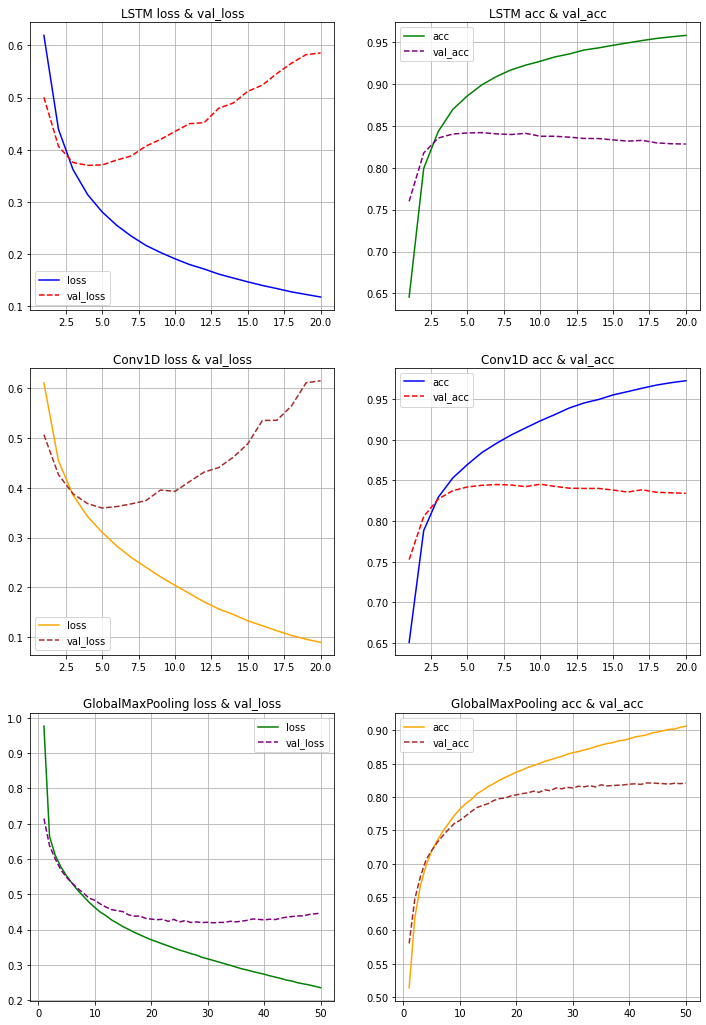

In [30]:
import matplotlib.pyplot as plt

lstm_dict = lstm_history.history
conv1d_dict = conv1d_history.history
gmaxp_dict = gmaxp_history.history

l_acc = lstm_dict['accuracy']
l_val_acc = lstm_dict['val_accuracy']
l_loss = lstm_dict['loss']
l_val_loss = lstm_dict['val_loss']

c_acc = conv1d_dict['accuracy']
c_val_acc = conv1d_dict['val_accuracy']
c_loss = conv1d_dict['loss']
c_val_loss = conv1d_dict['val_loss']

g_acc = gmaxp_dict['accuracy']
g_val_acc = gmaxp_dict['val_accuracy']
g_loss = gmaxp_dict['loss']
g_val_loss = gmaxp_dict['val_loss']

epochs = range(1, len(l_acc) + 1)
epochs_g = range(1, len(g_acc)+ 1)

fig, axs = plt.subplots(3, 2, figsize=(12, 18))

axs[0, 0].plot(epochs, l_loss, label='loss', linestyle='-', color='blue')
axs[0, 0].plot(epochs, l_val_loss, label='val_loss', linestyle='--', color='red')
axs[0, 0].set_title('LSTM loss & val_loss')
axs[0, 0].legend()
axs[0, 0].grid(True)

axs[0, 1].plot(epochs, l_acc, label='acc', linestyle='-', color='green')
axs[0, 1].plot(epochs, l_val_acc, label='val_acc', linestyle='--', color='purple')
axs[0, 1].set_title('LSTM acc & val_acc')
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[1, 0].plot(epochs, c_loss, label='loss', linestyle='-', color='orange')
axs[1, 0].plot(epochs, c_val_loss, label='val_loss', linestyle='--', color='brown')
axs[1, 0].set_title('Conv1D loss & val_loss')
axs[1, 0].legend()
axs[1, 0].grid(True)

axs[1, 1].plot(epochs, c_acc, label='acc', linestyle='-', color='blue')
axs[1, 1].plot(epochs, c_val_acc, label='val_acc', linestyle='--', color='red')
axs[1, 1].set_title('Conv1D acc & val_acc')
axs[1, 1].legend()
axs[1, 1].grid(True)

axs[2, 0].plot(epochs_g, g_loss, label='loss', linestyle='-', color='green')
axs[2, 0].plot(epochs_g, g_val_loss, label='val_loss', linestyle='--', color='purple')
axs[2, 0].set_title('GlobalMaxPooling loss & val_loss')
axs[2, 0].legend()
axs[2, 0].grid(True)

axs[2, 1].plot(epochs_g, g_acc, label='acc', linestyle='-', color='orange')
axs[2, 1].plot(epochs_g, g_val_acc, label='val_acc', linestyle='--', color='brown')
axs[2, 1].set_title('GlobalMaxPooling acc & val_acc')
axs[2, 1].legend()
axs[2, 1].grid(True)

plt.show()

이유는 잘 모르겠으나 pretrained 임베딩을 사용해도 성능은 향상되지 않았다.

### LSTM 하이퍼파라미터 조정하여 테스트
- 수업 종료 후 에포크를 20회 이상으로 하여 테스트해서 깃헙에 올려놓겠습니다.

In [31]:
from tensorflow.keras.layers import Dropout
lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))
lstm_model.add(tf.keras.layers.LSTM(16, return_sequences=True, recurrent_dropout=0.2))
lstm_model.add(tf.keras.layers.LSTM(8, recurrent_dropout=0.2))
lstm_model.add(tf.keras.layers.Dense(8, activation='relu'))
lstm_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 41, 100)           5000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 41, 16)            7488      
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 5,008,369
Trainable params: 5,008,369
Non-trainable params: 0
_________________________________________________________________


In [32]:
lstm_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=30

lstm_history = lstm_model.fit(partial_X_train,
                    partial_Y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, Y_val),
                    verbose=1)

lstm_results = lstm_model.evaluate(X_test,  y_test, verbose=2)

print(lstm_results)

Epoch 1/30
247/247 [==============================] - 67s 258ms/step - loss: 0.5291 - accuracy: 0.7305 - val_loss: 0.4272 - val_accuracy: 0.8051
Epoch 2/30
247/247 [==============================] - 64s 258ms/step - loss: 0.3876 - accuracy: 0.8302 - val_loss: 0.3740 - val_accuracy: 0.8354
Epoch 3/30
247/247 [==============================] - 63s 257ms/step - loss: 0.3309 - accuracy: 0.8599 - val_loss: 0.3544 - val_accuracy: 0.8442
Epoch 4/30
247/247 [==============================] - 63s 257ms/step - loss: 0.2920 - accuracy: 0.8807 - val_loss: 0.3649 - val_accuracy: 0.8444
Epoch 5/30
247/247 [==============================] - 64s 259ms/step - loss: 0.2619 - accuracy: 0.8955 - val_loss: 0.3540 - val_accuracy: 0.8524
Epoch 6/30
247/247 [==============================] - 63s 257ms/step - loss: 0.2369 - accuracy: 0.9074 - val_loss: 0.3638 - val_accuracy: 0.8518
Epoch 7/30
247/247 [==============================] - 63s 256ms/step - loss: 0.2157 - accuracy: 0.9177 - val_loss: 0.3773 - val_ac

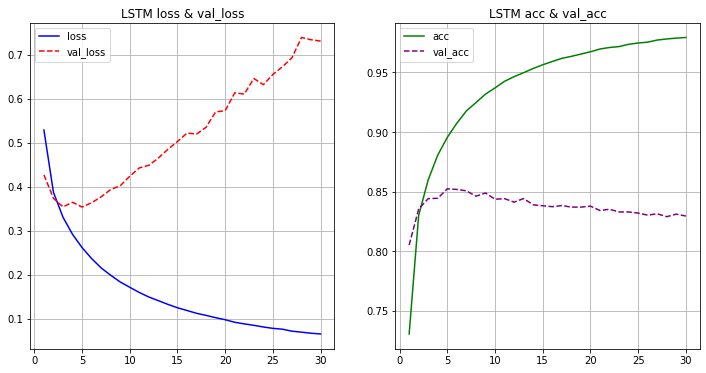

In [33]:
lstm_dict = lstm_history.history

l_acc = lstm_dict['accuracy']
l_val_acc = lstm_dict['val_accuracy']
l_loss = lstm_dict['loss']
l_val_loss = lstm_dict['val_loss']

epochs = range(1, len(l_acc) + 1)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(epochs, l_loss, label='loss', linestyle='-', color='blue')
axs[0].plot(epochs, l_val_loss, label='val_loss', linestyle='--', color='red')
axs[0].set_title('LSTM loss & val_loss')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(epochs, l_acc, label='acc', linestyle='-', color='green')
axs[1].plot(epochs, l_val_acc, label='val_acc', linestyle='--', color='purple')
axs[1].set_title('LSTM acc & val_acc')
axs[1].legend()
axs[1].grid(True)

### 회고
- 비록 pretrained임베딩을 사용한 모델에서는 기대하던 성능향상이 없었지만 기존 임베딩을 사용한 모델들에서 약 epochs 5회 부근에서 val_accuracy가 0.85를 넘겼다.
- lstm에서 레이어를 추가하고 과적합을 방지하기 위해 recurrent_dropout을 추가해 실험을 진행해 보았다. 하지만 학습시간이 에포크당 1분이 넘게 걸렸다.
- 만들어진 임베딩벡터에서는 유사 단어가 훈련을 할때마다 아예 다른것들로 채워지는 모습을 볼 수 있었다.
- 단어수를 10000개도 해보고 30000개, 50000개도 해보았으나 큰 성능차이는 보여지지 않았다.

### 보완할 점
- 데이터셋의 문장을 봤을 때 띄워쓰기가 잘 되지않은 문장도 있었고, 구분자로 시작하는 단어도 있었다. 이것들에 대해 좀더 명확히 구분할 수 있는 알고리즘을 사용해야 한다.
- 시간관계상 수업시간에 레이어를 수정한 lstm모델의 에포크 수를 충분히 가저가지 못했다.

### 기존 임베딩 사용 모델 테스트

In [34]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
lstm_model.add(tf.keras.layers.LSTM(8))
lstm_model.add(tf.keras.layers.Dense(8, activation='relu'))
lstm_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

lstm_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [35]:
lstm_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20

lstm_history = lstm_model.fit(partial_X_train,
                    partial_Y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, Y_val),
                    verbose=1)

lstm_results = lstm_model.evaluate(X_test,  y_test, verbose=2)

print(lstm_results)

Epoch 1/20
247/247 [==============================] - 3s 7ms/step - loss: 0.4997 - accuracy: 0.7695 - val_loss: 0.3723 - val_accuracy: 0.8436
Epoch 2/20
247/247 [==============================] - 1s 5ms/step - loss: 0.3455 - accuracy: 0.8551 - val_loss: 0.3484 - val_accuracy: 0.8502
Epoch 3/20
247/247 [==============================] - 1s 5ms/step - loss: 0.3212 - accuracy: 0.8669 - val_loss: 0.3482 - val_accuracy: 0.8489
Epoch 4/20
247/247 [==============================] - 1s 5ms/step - loss: 0.3110 - accuracy: 0.8720 - val_loss: 0.3499 - val_accuracy: 0.8490
Epoch 5/20
247/247 [==============================] - 1s 5ms/step - loss: 0.3033 - accuracy: 0.8751 - val_loss: 0.3519 - val_accuracy: 0.8515
Epoch 6/20
247/247 [==============================] - 1s 5ms/step - loss: 0.2973 - accuracy: 0.8790 - val_loss: 0.3513 - val_accuracy: 0.8510
Epoch 7/20
247/247 [==============================] - 1s 5ms/step - loss: 0.2898 - accuracy: 0.8817 - val_loss: 0.3521 - val_accuracy: 0.8499
Epoch 

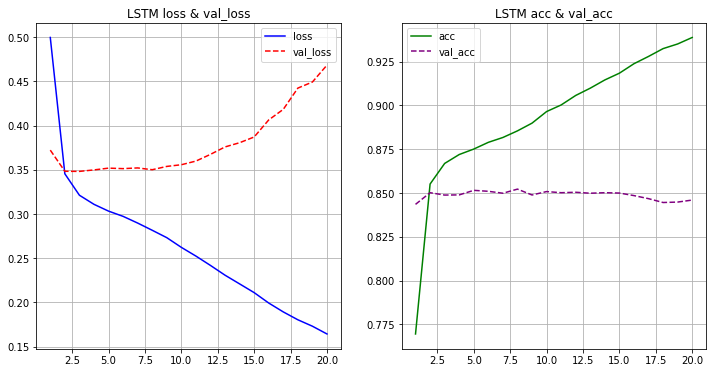

In [36]:
lstm_dict = lstm_history.history

l_acc = lstm_dict['accuracy']
l_val_acc = lstm_dict['val_accuracy']
l_loss = lstm_dict['loss']
l_val_loss = lstm_dict['val_loss']

epochs = range(1, len(l_acc) + 1)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(epochs, l_loss, label='loss', linestyle='-', color='blue')
axs[0].plot(epochs, l_val_loss, label='val_loss', linestyle='--', color='red')
axs[0].set_title('LSTM loss & val_loss')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(epochs, l_acc, label='acc', linestyle='-', color='green')
axs[1].plot(epochs, l_val_acc, label='val_acc', linestyle='--', color='purple')
axs[1].set_title('LSTM acc & val_acc')
axs[1].legend()
axs[1].grid(True)

### 추가실험 회고
- 레이어를 추가한 모델에서는 기존임베딩을 사용한 것보다 아주 약간의 성능 향상이 있었다.